# **Modelos Benchmarks**

In [78]:
# Librerias Importadas

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
from xgboost.callback import EarlyStopping


In [3]:
# Cargar datos
df = pd.read_csv(r"C:\Users\TAWTOCA\OneDrive - Universidad del Norte\Documentos\Visual Files\Rentabilidad_filtrado.csv")



df.head()

,FECHA_CORTE,TIPO_ENTIDAD,NOMBRE_TIPO_ENTIDAD,CODIGO_ENTIDAD,NOMBRE_ENTIDAD,TIPO_NEGOCIO,NOMBRE_TIPO_PATRIMONIO,SUBTIPO_NEGOCIO,NOMBRE_SUBTIPO_PATRIMONIO,CODIGO_NEGOCIO,...,VALOR_UNIDAD_OPERACIONES_DIA_T,APORTES_RECIBIDOS,RETIROS_REDENCIONES,ANULACIONES,VALOR_FONDO_CIERRE_DIA_T,NUMERO_INVERSIONISTAS,RENTABILIDAD_DIARIA,RENTABILIDAD_MENSUAL,RENTABILIDAD_SEMESTRAL,RENTABILIDAD_ANUAL
0,06/07/2020,5,SF-SOCIEDAD FIDUCIARIA,39,Fiduagraria S.A.,9,FONDOS DE INVERSIÓN COLECTIVA,1,FIC DE TIPO GENERAL,69537,...,12889.679298,6.293444e+07,4.416386e+07,0.0,2.959867e+08,2.0,6.830705,0.799843,3.053366,2.881620
1,23/08/2023,5,SF-SOCIEDAD FIDUCIARIA,39,Fiduagraria S.A.,9,FONDOS DE INVERSIÓN COLECTIVA,1,FIC DE TIPO GENERAL,69537,...,15457.741094,1.058423e+09,1.491934e+08,5388920.8,3.469729e+11,9.0,16.385587,9.782180,12.968587,12.937892
2,31/05/2024,85,COMISIONISTAS DE BOLSA DE VALORES,3,Acciones Y Valores S.A. Comisionistas De Bolsa,9,FONDOS DE INVERSIÓN COLECTIVA,3,FIC INMOBILIARIAS,90278,...,13373.374363,0.000000e+00,6.300000e-01,0.0,7.468954e+10,1220.0,13.696138,9.459348,5.120448,4.883773
3,09/09/2022,5,SF-SOCIEDAD FIDUCIARIA,40,Fiducoldex,9,FONDOS DE INVERSIÓN COLECTIVA,1,FIC DE TIPO GENERAL,11149,...,19578.174949,4.757419e+07,1.352728e+08,0.0,2.549026e+10,90.0,12.734325,8.892954,5.016920,3.043771
4,01/10/2022,5,SF-SOCIEDAD FIDUCIARIA,3,Bbva Asset Management S.A. Sociedad Fiduciaria,9,FONDOS DE INVERSIÓN COLECTIVA,1,FIC DE TIPO GENERAL,87342,...,11265.384058,0.000000e+00,3.080000e+00,0.0,9.718136e+10,27052.0,13.098794,10.536135,6.619211,4.480745


In [4]:
(df == 0).sum()


FECHA_CORTE                                              0
TIPO_ENTIDAD                                             0
NOMBRE_TIPO_ENTIDAD                                      0
CODIGO_ENTIDAD                                           0
NOMBRE_ENTIDAD                                           0
TIPO_NEGOCIO                                             0
NOMBRE_TIPO_PATRIMONIO                                   0
SUBTIPO_NEGOCIO                                          0
NOMBRE_SUBTIPO_PATRIMONIO                                0
CODIGO_NEGOCIO                                           0
NOMBRE_PATRIMONIO                                        0
PRINCIPAL_COMPARTIMENTO                                  0
TIPO_PARTICIPACION                                       0
RENDIMIENTOS_ABONADOS                                  778
PRECIERRE_FONDO_DIA_T                                  247
NUMERO_UNIDADES_FONDO_CIERRE_OPER_DIA_T_ANTERIOR       245
VALOR_UNIDAD_OPERACIONES_DIA_T                          

In [35]:
# Definir variables predictoras y respuesta
X = df[["APORTES_RECIBIDOS", "TIPO_PARTICIPACION", "PRECIERRE_FONDO_DIA_T",  "NUMERO_INVERSIONISTAS"]]
y = df["RETIROS_REDENCIONES"]



# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## **Funciones**

In [36]:
def analizar_residuos(residuos, ljung_box_p_value):
    """
    Aplica transformaciones a los residuos y genera gráficos.
    
    Parámetros:
    - residuos: array-like, residuos del modelo.
    - ljung_box_p_value: float, p-valor de la prueba de Ljung-Box.
    """
    # Aplicar transformaciones
    residuos_esc = (residuos - np.mean(residuos)) / np.std(residuos)  # Escalar residuos
    residuos_log = np.log1p(np.abs(residuos)) * np.sign(residuos)  # Log-transformación
    
    # Crear figura con dos subgráficos
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # 📊 Gráfico 1: ACF de los residuos escalados
    plot_acf(residuos_esc, ax=axes[0], lags=30)
    axes[0].set_title(f"ACF de los Residuos Escalados\nLjung-Box: {ljung_box_p_value:.4f}")
    
    # 📊 Gráfico 2: Histograma de los residuos log-transformados
    sns.histplot(residuos_log, bins=30, kde=True, ax=axes[1])
    axes[1].set_title("Histograma de los Residuos Log-transformados")
    axes[1].set_xlabel("Valor del Residuo Transformado")
    
    # Ajustar diseño y mostrar gráficos
    plt.tight_layout()
    plt.show()

In [37]:
def scatter_real_vs_pred(y_test, y_test_pred):
    """
    Crea un gráfico de dispersión comparando los valores reales vs los predichos.
    
    Parámetros:
    - y_test: array-like, valores reales.
    - y_test_pred: array-like, valores predichos.
    """
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.5)
    
    # Agregar línea de referencia y etiquetas
    plt.axline((0, 0), slope=1, color="red", linestyle="--", label="Línea Ideal (y=x)")
    plt.xlabel("Valor Real")
    plt.ylabel("Valor Predicho")
    plt.title("Dispersión: Real vs Predicho")
    plt.legend()
    
    # Mostrar gráfico
    plt.show()

In [38]:
def calcular_metricas(y_test, y_test_pred):
    """
    Calcula métricas de error y realiza pruebas estadísticas sobre los residuos.
    
    Parámetros:
    - y_test: array-like, valores reales.
    - y_test_pred: array-like, valores predichos.
    
    Retorna:
    - DataFrame con métricas MAPE, RMSE, R², Ljung-Box p-value y Jarque-Bera p-value.
    - Residuos calculados.
    """
    # Calcular métricas
    mae = mean_absolute_percentage_error(y_test, y_test_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2 = r2_score(y_test, y_test_pred)
    
    # Residuos
    residuos = y_test - y_test_pred
    
    # Pruebas estadísticas
    ljung_box_p_value = acorr_ljungbox(residuos, lags=[10]).iloc[0, 1]
    jarque_bera_p_value = jarque_bera(residuos)[1]
    
    # Crear DataFrame con resultados
    resultados = pd.DataFrame({
        "MAPE": [mae],
        "RMSE": [rmse],
        "R²": [r2],
        "Ljung-Box p-value": [ljung_box_p_value],
        "Jarque-Bera p-value": [jarque_bera_p_value]
    })
    
    return resultados, residuos, ljung_box_p_value

## **Regresión Lineal**

In [39]:
lr = LinearRegression().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

Training set score: 0.72
Test set score: 0.69


La diferencia entre entrenamiento y prueba es pequeña, lo que sugiere que el modelo no está sobreajustando.

In [40]:
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [41]:
resultados, residuos, ljung_box_p_value = calcular_metricas(y_test, y_test_pred)
print(resultados)

           MAPE          RMSE        R²  Ljung-Box p-value  \
0  1.666605e+09  2.432348e+10  0.693748           0.714567   

   Jarque-Bera p-value  
0                  0.0  


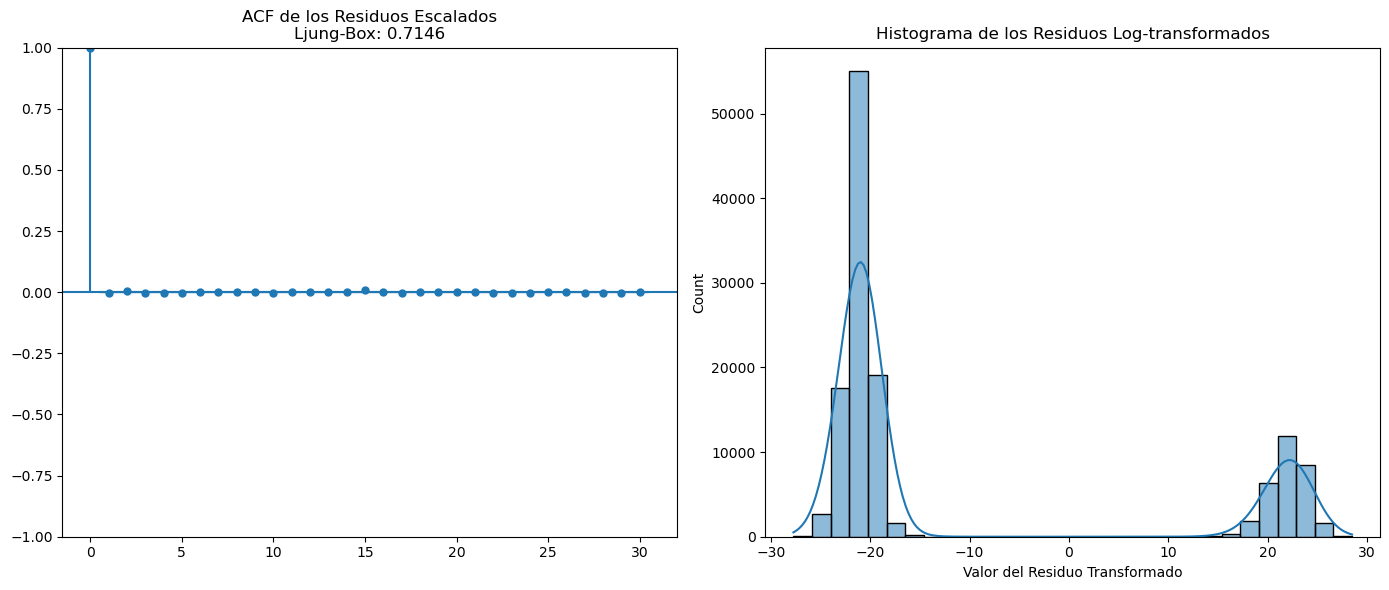

In [42]:
analizar_residuos(residuos, ljung_box_p_value)

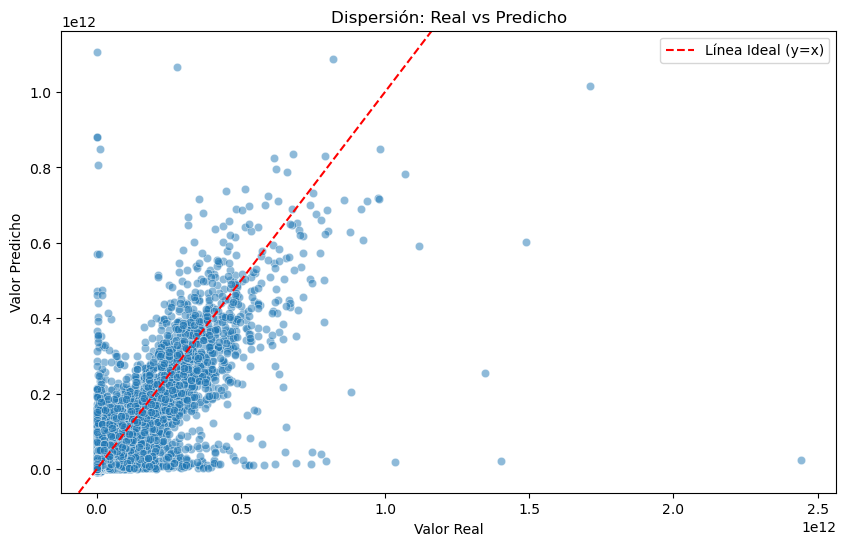

In [43]:
scatter_real_vs_pred(y_test, y_test_pred)

## **Regresión de Ridge**

In [68]:
ridge = Ridge().fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge.score(X_test, y_test)))

Training set score: 0.72
Test set score: 0.69


In [70]:
ridgeo = Ridge(solver='saga').fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridgeo.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridgeo.score(X_test, y_test)))

Training set score: 0.72
Test set score: 0.69


In [47]:
y_test_pred = ridge.predict(X_test)

resultados, residuos, ljung_box_p_value = calcular_metricas(y_test, y_test_pred)
print(resultados)


           MAPE          RMSE        R²  Ljung-Box p-value  \
0  1.666630e+09  2.432347e+10  0.693748           0.714566   

   Jarque-Bera p-value  
0                  0.0  


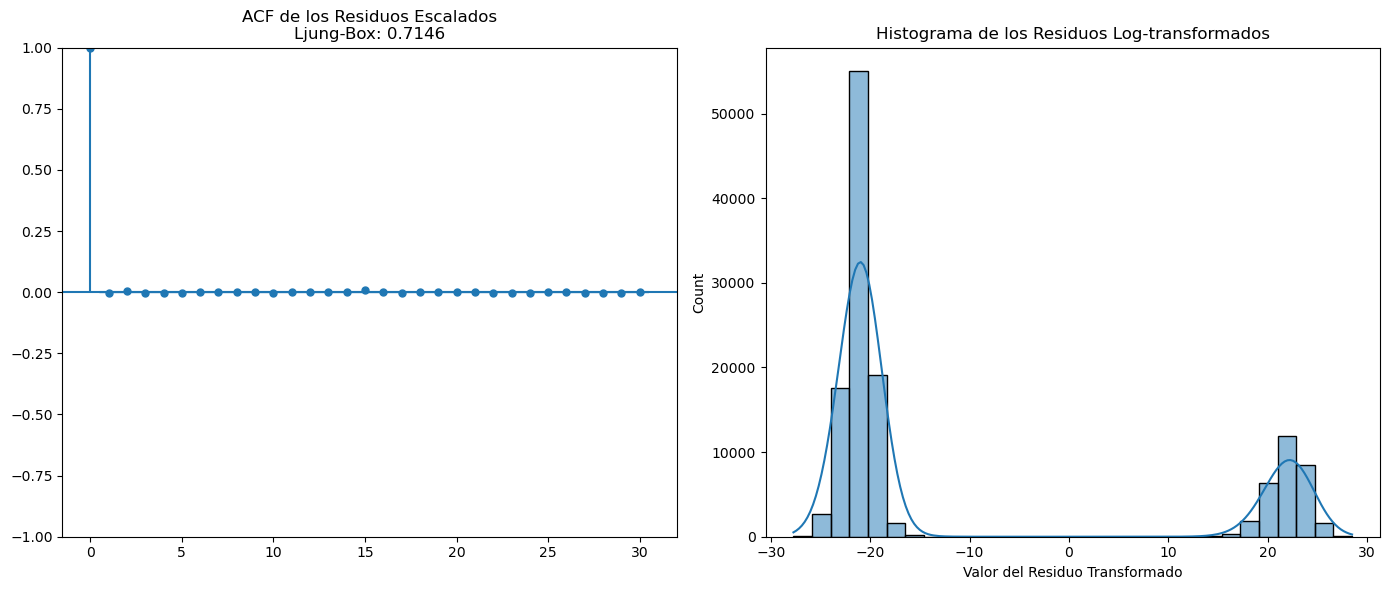

In [48]:
analizar_residuos(residuos, ljung_box_p_value)

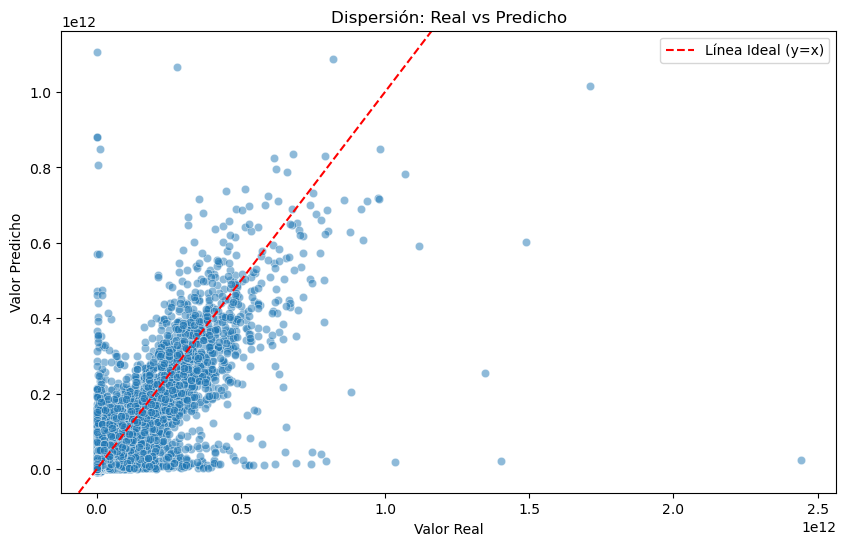

In [49]:
scatter_real_vs_pred(y_test, y_test_pred)

## **Lasso**

In [71]:
lasso = Lasso().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso.score(X_test, y_test)))
print("Number of features used: {}".format(np.sum(lasso.coef_ != 0)))

Training set score: 0.72
Test set score: 0.69
Number of features used: 4


In [51]:

y_test_pred = lasso.predict(X_test)

In [52]:
resultados, residuos, ljung_box_p_value = calcular_metricas(y_test, y_test_pred)
print(resultados)

           MAPE          RMSE        R²  Ljung-Box p-value  \
0  1.666605e+09  2.432348e+10  0.693748           0.714567   

   Jarque-Bera p-value  
0                  0.0  


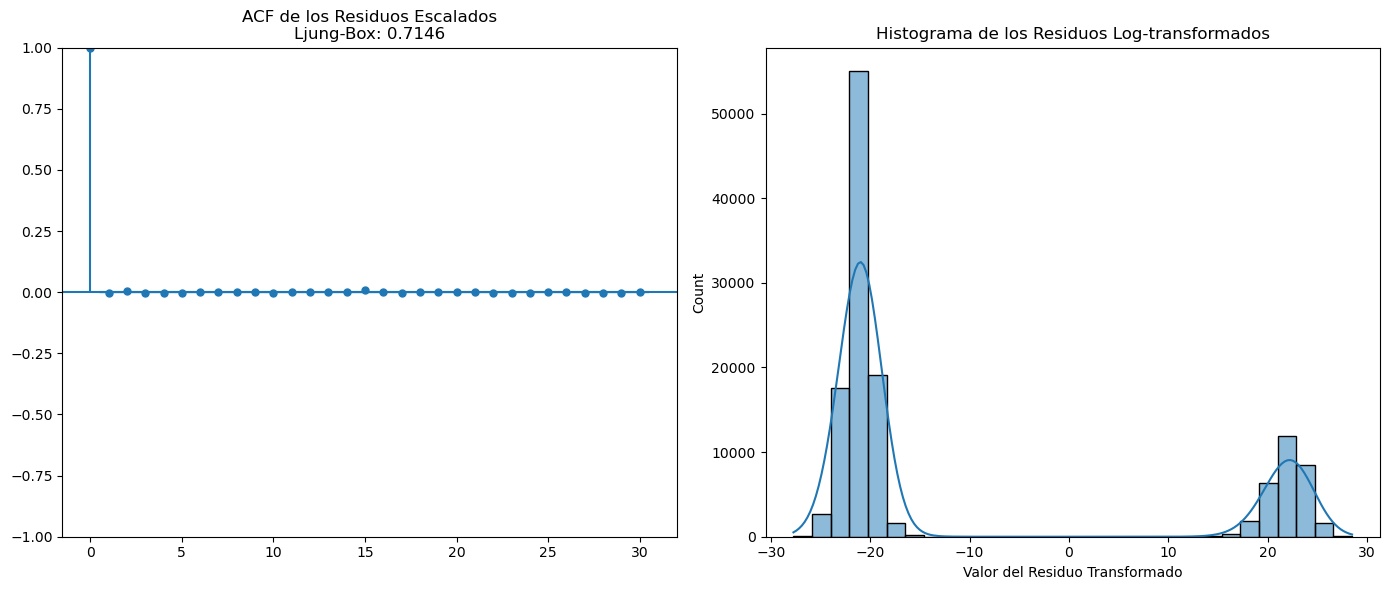

In [53]:
analizar_residuos(residuos, ljung_box_p_value)

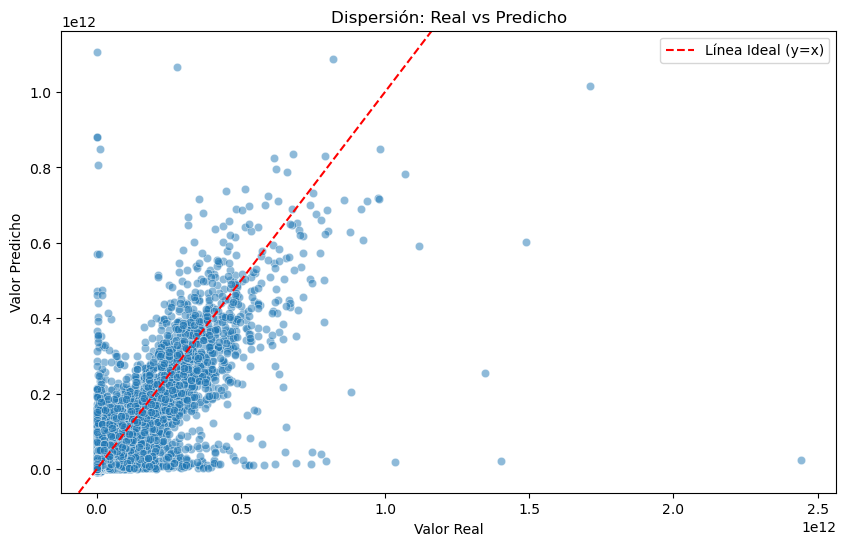

In [54]:
scatter_real_vs_pred(y_test, y_test_pred)

## **KNN**

In [55]:
KNN = KNeighborsRegressor(n_neighbors=5, weights='uniform')
    
    # Entrenar el modelo
KNN.fit(X_train, y_train)
    
    # Predicciones
y_train_pred = KNN.predict(X_train)
y_test_pred = KNN.predict(X_test)
    
    # Calcular R²
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
    
    # Imprimir resultados
print(f'R² en entrenamiento: {train_r2:.4f}')
print(f'R² en prueba: {test_r2:.4f}')

R² en entrenamiento: 0.7816
R² en prueba: 0.7304


### Metricas y Graficos

In [56]:
resultados, residuos, ljung_box_p_value = calcular_metricas(y_test, y_test_pred)
print(resultados)

           MAPE          RMSE        R²  Ljung-Box p-value  \
0  1.088466e+09  2.282136e+10  0.730406           0.575309   

   Jarque-Bera p-value  
0                  0.0  


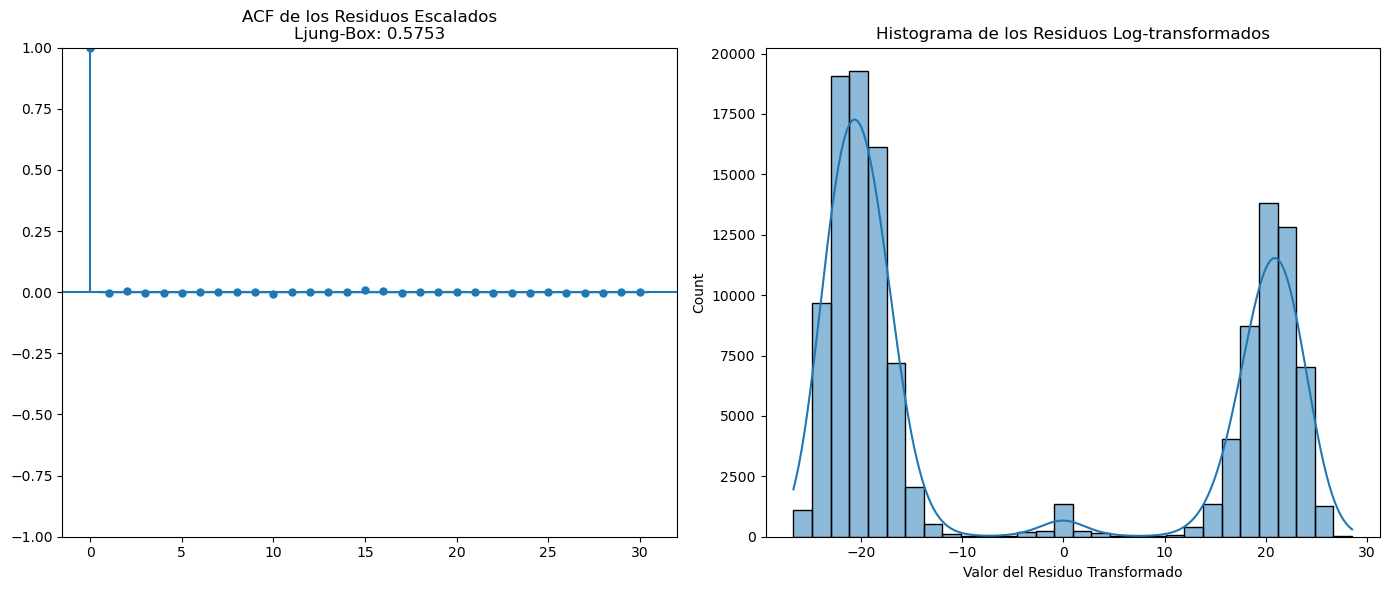

In [57]:
analizar_residuos(residuos, ljung_box_p_value)

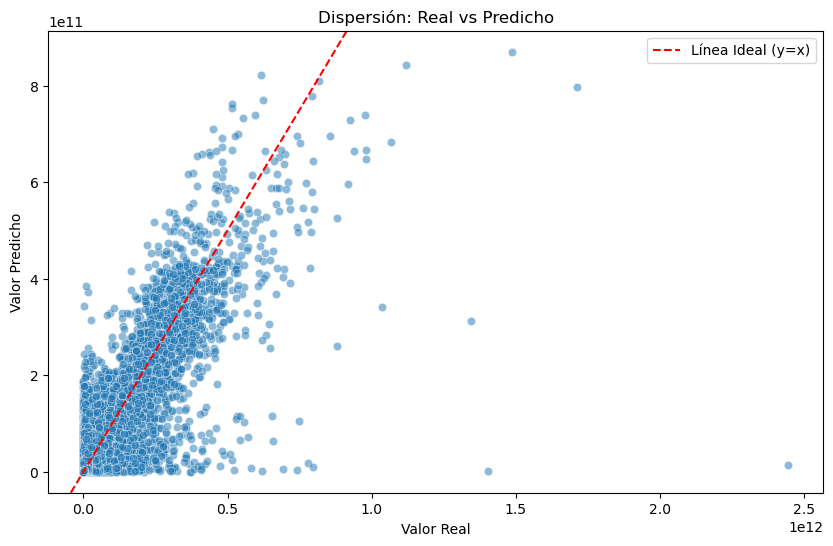

In [58]:
scatter_real_vs_pred(y_test, y_test_pred)

### Optimizado

In [66]:
KNN = KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='ball_tree')
KNN.fit(X_train, y_train)
    
    # Predicciones
y_train_pred = KNN.predict(X_train)
y_test_pred = KNN.predict(X_test)
    
    # Calcular R²
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
    
    # Imprimir resultados
print(f'R² en entrenamiento: {train_r2:.4f}')
print(f'R² en prueba: {test_r2:.4f}')

R² en entrenamiento: 0.7816
R² en prueba: 0.7304


## **Random Forest**

In [37]:
RANFOR = RandomForestRegressor(n_estimators=100, random_state=42)
RANFOR.fit(X_train, y_train)

# Predicciones
y_train_pred = RANFOR.predict(X_train)
y_test_pred = RANFOR.predict(X_test)

    # Imprimir R²
print(f'R² en entrenamiento: {r2_score(y_train, y_train_pred):.4f}')
print(f'R² en prueba: {r2_score(y_test, y_test_pred):.4f}')

R² en entrenamiento: 0.9930
R² en prueba: 0.9522


In [38]:
resultados, residuos, ljung_box_p_value = calcular_metricas(y_test, y_test_pred)
print(resultados)

           MAPE          RMSE        R²  Ljung-Box p-value  \
0  1.267829e+23  2.132692e+11  0.952204           0.069527   

   Jarque-Bera p-value  
0                  0.0  


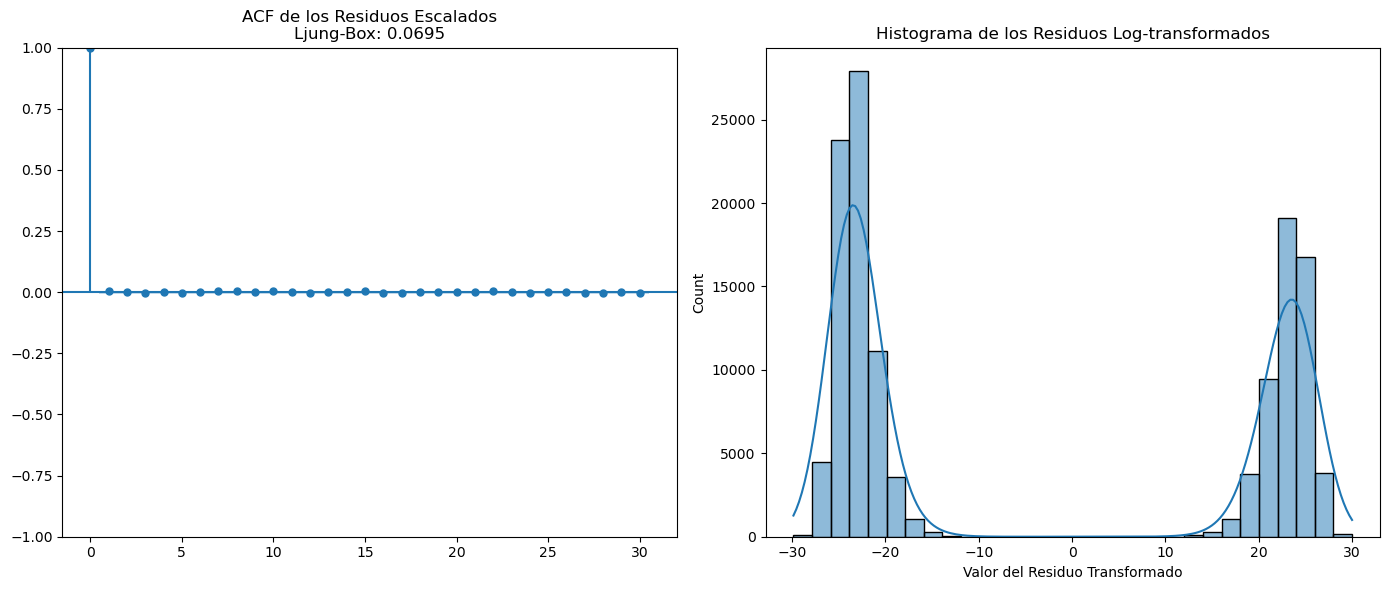

In [39]:
analizar_residuos(residuos, ljung_box_p_value)

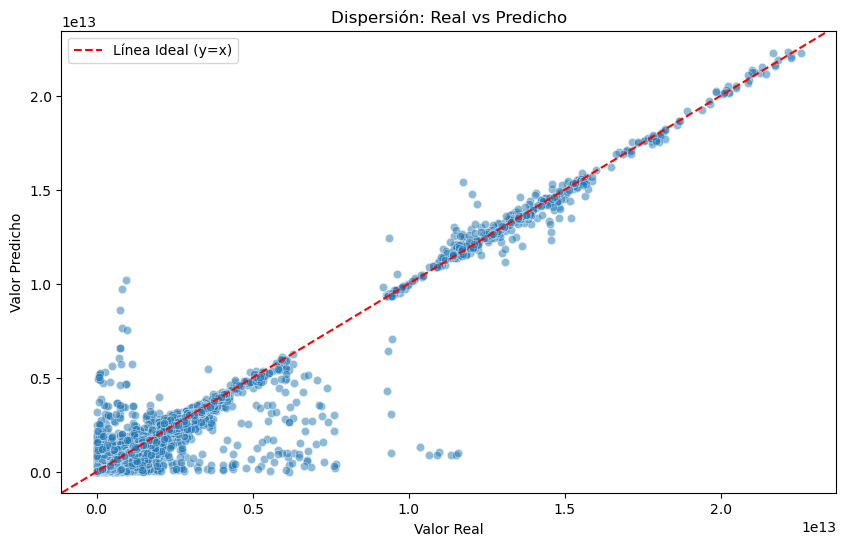

In [40]:
scatter_real_vs_pred(y_test, y_test_pred)

## **XGBoost**

In [59]:
XGB = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42, n_jobs=-1)
    
    # Entrenar el modelo
XGB.fit(X_train, y_train)
    
    # Predicciones
y_train_pred = XGB.predict(X_train)
y_test_pred = XGB.predict(X_test)
    
    # Calcular R²
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
    
    # Imprimir resultados
print(f'R² en entrenamiento: {train_r2:.4f}')
print(f'R² en prueba: {test_r2:.4f}')

R² en entrenamiento: 0.8204
R² en prueba: 0.6527


In [63]:
XGB = XGBRegressor(
    n_estimators=500,        # Aumentar número de árboles
    learning_rate=0.05,      # Reducir tasa de aprendizaje
    max_depth=4,             # Menos profundidad para evitar sobreajuste
    min_child_weight=5,      # Aumentar para evitar divisiones innecesarias
    subsample=0.8,           # Muestra aleatoria del 80% de los datos en cada árbol
    colsample_bytree=0.8,    # Selección aleatoria del 80% de las características
    reg_alpha=0.1,           # Regularización L1 (Lasso)
    reg_lambda=1,            # Regularización L2 (Ridge)
    random_state=42,
    n_jobs=-1
)

    # Entrenar el modelo
XGB.fit(X_train, y_train)
    
    # Predicciones
y_train_pred = XGB.predict(X_train)
y_test_pred = XGB.predict(X_test)
    
    # Calcular R²
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
    
    # Imprimir resultados
print(f'R² en entrenamiento: {train_r2:.4f}')
print(f'R² en prueba: {test_r2:.4f}')

R² en entrenamiento: 0.7756
R² en prueba: 0.7284


In [88]:
XGB = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, early_stopping_rounds=20,
    min_child_weight=5,     # Controlar la división de nodos para evitar sobreajuste
    subsample=0.8,          # Tomar muestras de los datos para evitar sobreajuste
    colsample_bytree=0.8,   # Seleccionar características aleatoriamente en cada árbol
    reg_alpha=0.1,          # Regularización L1 (reduce complejidad)
    reg_lambda=1,           # Regularización L2 (evita sobreajuste)
    tree_method='hist',     # Algoritmo optimizado para conjuntos grandes
    eval_metric="rmse",  random_state=42, n_jobs=-1)
XGB.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_test, y_test)]) 

    # Predicciones
y_train_pred = XGB.predict(X_train)
y_test_pred = XGB.predict(X_test)
    
    # Calcular R²
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
    
    # Imprimir resultados
print(f'R² en entrenamiento: {train_r2:.4f}')
print(f'R² en prueba: {test_r2:.4f}')

[0]	validation_0-rmse:42468322293.40520	validation_1-rmse:41452057425.78026
[1]	validation_0-rmse:39796130962.37191	validation_1-rmse:38653855143.97895
[2]	validation_0-rmse:37493042172.51770	validation_1-rmse:36217760143.32058
[3]	validation_0-rmse:36002353743.92764	validation_1-rmse:34634967824.01650
[4]	validation_0-rmse:34169116100.23349	validation_1-rmse:32733518174.98832
[5]	validation_0-rmse:32622544172.43632	validation_1-rmse:31105109820.57277
[6]	validation_0-rmse:31283863699.12350	validation_1-rmse:29730958762.81546
[7]	validation_0-rmse:30207823065.12201	validation_1-rmse:28554741672.72985
[8]	validation_0-rmse:29312173207.86364	validation_1-rmse:27579520824.42250
[9]	validation_0-rmse:28490686120.97861	validation_1-rmse:26770698973.36637
[10]	validation_0-rmse:27792473082.42578	validation_1-rmse:26065631263.02192
[11]	validation_0-rmse:27258629268.99134	validation_1-rmse:25489433245.77809
[12]	validation_0-rmse:26726342387.53675	validation_1-rmse:24996647893.69337
[13]	vali

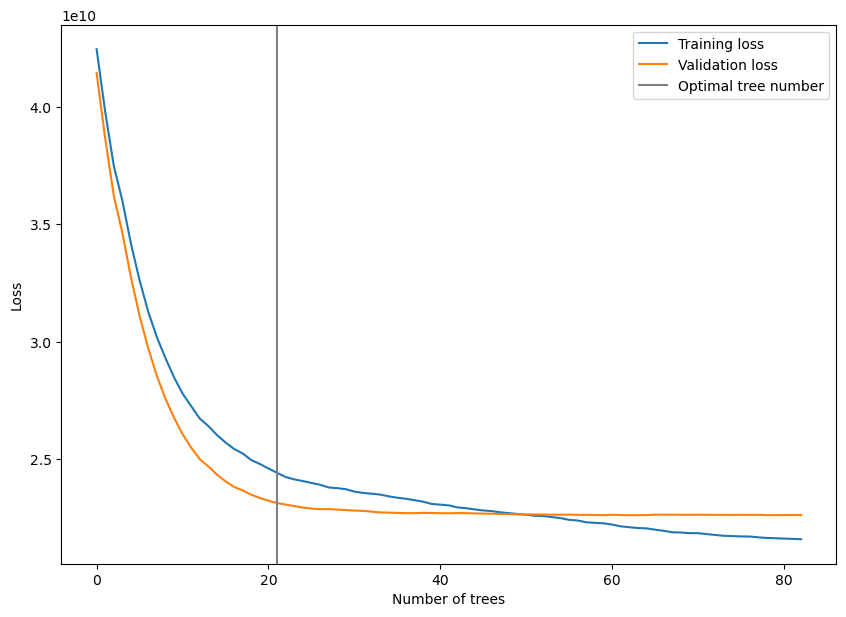

In [90]:
results = XGB.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(21, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [91]:
resultados, residuos, ljung_box_p_value = calcular_metricas(y_test, y_test_pred)
print(resultados)

           MAPE          RMSE        R²  Ljung-Box p-value  \
0  1.128142e+09  2.260692e+10  0.735448           0.535113   

   Jarque-Bera p-value  
0                  0.0  


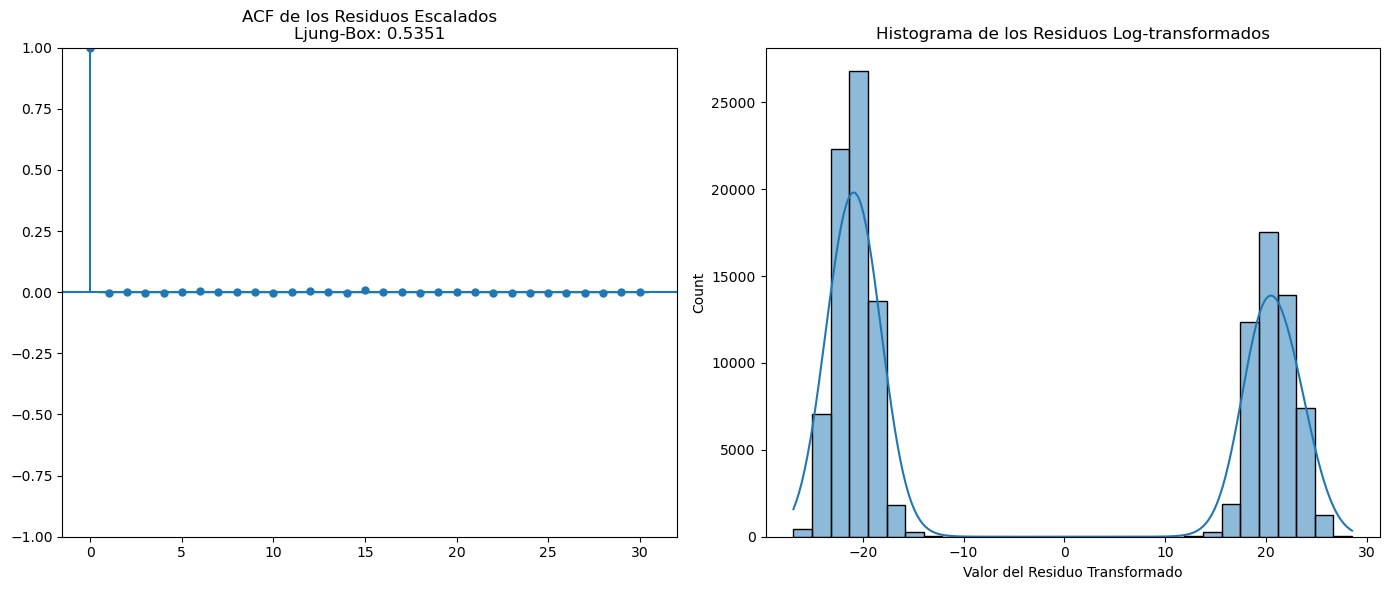

In [92]:
analizar_residuos(residuos, ljung_box_p_value)

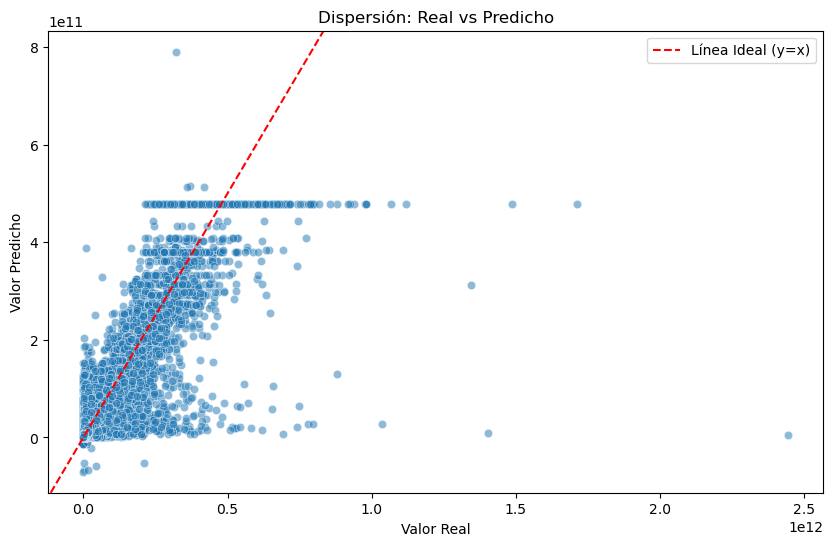

In [93]:
scatter_real_vs_pred(y_test, y_test_pred)